# Selección de portafolios usando simulación Montecarlo

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6e/Separation_theorem_of_MPT.svg/2000px-Separation_theorem_of_MPT.svg.png" width="400px" height="400px" />

> Durante el curso, específicamente en los módulos dos y tres, elaboramos toda la fundamentación de la teoría moderna de portafolios de Markowitz. Ésta se basa en la existencia de una línea especial en el espacio de rendimiento esperado vs. volatilidad, llamada **frontera de mínima varianza**.

> Al finalizar el módulo 3, vimos que no importa la cantidad de activos riesgosos que se tengan, si encontramos dos portafolios sobre la frontera eficiente, podemos reconstruirla. Dos portafolios importantes que hallamos en el curso fueron:

> - **Portafolio de mínima varianza**: minimizando la varianza.
> - **Portafolio eficiente en media varianza**: maximizando el radio de Sharpe.

> Por otra parte, resolver problemas de optimización cuando la cantidad de variables crece, se vuelve un problema complejo, computacionalmente hablando. Así que desarrollar métodos alternativos a la optimización que nos permitan encontrar los anteriores portafolios es de gran interés...

## 1. Descargamos activos de la BMV

Por simplicidad, y para entender las ideas alrededor de la selección de portafolios usando simulación montecarlo, utilizaremos únicamente tres activos de la BMV: 
- Grupo México(AMXL.MX)
- Walmart de Mexico SAB de CV	(WALMEX.MX) 
- BIMBO (BIMBOA.MX)
- Banorte (GFBANORTEO.MX)

1.1. Descargar precios mensuales ajustados en el cierre para los tres activos mencionados anteriormente en los últimos 5 años:

In [1]:
# Bajamos los ETF de yahoo
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

tickers = ['GMEXICOB.MX', 'WALMEX.MX', 'GFNORTEO.MX', 'BIMBOA.MX']
start_date = '2015-01-01'


St = yf.download(tickers, start=start_date)['Adj Close']
St.head()
rt = St.pct_change().dropna()

# Download IPC
St_ipc = yf.download(['^MXX', 'WALMEX.MX'], start=start_date)['Close']
St_ipc.head()
rt_ipc = St_ipc.pct_change().dropna()



[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  2 of 2 completed


1.2. A partir de los precios, obtener los rendimientos mensuales:

1.3. Finalmente, a partir de los rendimientos mensuales, estimar la tendencia central de los rendimientos (rendimiento esperado), y caracterizar el riesgo de los activos (varianzas y covarianzas)

In [2]:
# Resumen: rendimiento medio mensual y volatilidad
summary = pd.DataFrame({
    'means': rt.mean() * 252,
    'volatility': rt.std() * np.sqrt(252)
})
summary

,means,volatility
BIMBOA.MX,0.126695,0.296677
GFNORTEO.MX,0.181779,0.330070
GMEXICOB.MX,0.189176,0.340778
WALMEX.MX,0.139654,0.249232


In [3]:
# Matriz de covarianza
sigma = rt.cov()

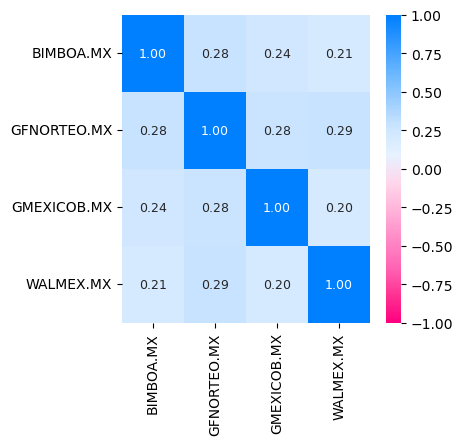

In [4]:
# Matriz de correlaciones

corr = rt.corr()

colors = ['#FF007F', '#FF3393', '#FF66B5', '#FF8AC7', '#FFB3D9', '#FFD6EB', 
          '#E6F2FF', '#CCE5FF', '#99CCFF', '#66B5FF', '#3399FF', '#007FFF']

custom_cmap = LinearSegmentedColormap.from_list("custom_pink_blue", colors)

plt.figure(figsize=(4,4))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = custom_cmap, annot = True, fmt = '.2f', annot_kws={"size": 9})
plt.show()

___
## 2. Selección de portafolios mediante montecarlo

Antes de continuar, consultamos la tasa libre de riesgo al día de hoy en [Banxico](http://www.banxico.org.mx/):

In [5]:
# Tasa libre de riesgo
rf = 0.1125

¿Alguien tiene alguna idea de lo que es simulación montecarlo?

En cuanto a la selección de portafolios, lo que hacemos es simular una gran cantidad de posibles portafolios que se pueden construir con los activos dados (generamos muchas ponderaciones posibles), y calculamos su rendimiento esperado y volatilidad para dibujarlos, y así poder identificar objetos de interés:

- frontera eficiente;
- portafolio de mínima varianza;
- portafolio EMV...

In [6]:
# Definimos el número de portafolios que simularemos, y la cantidad de activos que tenemos
n_port = 1000
n_act = len(rt.keys())
n_port, n_act

(1000, 4)

2.1. Generamos los portafolios

np.random.dirichlet((1,) * n_act, size=1)

In [7]:
# Simula numeros aleatorios 

w_sim = np.random.dirichlet((1,) * n_act, size=1)
w_sim

array([[0.81154006, 0.00879183, 0.12278037, 0.05688774]])

In [8]:
# Calcula el rendimiento de esa simulacion 
w_sim.dot(summary.means)

array([0.1355875])

In [9]:
# Calcula la varianza de esa simulacion
np.sqrt(w_sim.dot(sigma).dot(w_sim.T)) * np.sqrt(252)

array([[0.25859622]])

In [10]:
# Generar una matriz de pesos de n_portafolios x n_activos,
# tal que cada fila sume uno (recordar restricción)
W = np.random.dirichlet((1,) * n_act, size=n_port)
W

array([[0.43691956, 0.31526697, 0.17434446, 0.07346901],
       [0.02708673, 0.03834361, 0.47769725, 0.45687241],
       [0.13519305, 0.57060678, 0.21141222, 0.08278795],
       ...,
       [0.19834604, 0.26223503, 0.09130146, 0.44811747],
       [0.34515755, 0.01052551, 0.28791099, 0.35640595],
       [0.25696533, 0.02744748, 0.18871047, 0.52687672]])

In [11]:
# Verificamos la forma de W
W.shape

(1000, 4)

$$E[P] = W * E[stocks_i] $$

In [12]:
# Obten los rendimientos
rendimientos = W.dot(rt.mean()) * 252

In [13]:
## Obten las volatilidades

$$Var(P) = W^T \Sigma W $$
$$\sigma_p = \sqrt{Var(P)}$$

W[i, :]

In [14]:
# Define un vector de ceros 
zeros = np.zeros(n_port)

In [15]:
# Calcula las volatilidades
for i in range(len(zeros)):
    zeros[i] = np.sqrt(W[i,:].dot(sigma).dot(W[i,:])) * np.sqrt(252)
volatility = zeros

$$Sharpe = \frac{E_s - rf}{\sigma_s}$$

In [16]:
# Radio de Sharpe
sharpe = (rendimientos - rf) / volatility

In [17]:
# Data frame de resultados
resultados = pd.DataFrame({
    'expected_value': rendimientos,
    'volatility': volatility,
    'sharpe': sharpe
})
resultados['w_bimbo'] = W[:,0]
resultados['w_banorte'] = W[:,1]
resultados['w_gmexico'] = W[:,2]
resultados['w_walmex'] = W[:,3]
resultados

,expected_value,volatility,sharpe,w_bimbo,w_banorte,w_gmexico,w_walmex
0,0.155906,0.220939,0.196462,0.436920,0.315267,0.174344,0.073469
1,0.164575,0.223847,0.232634,0.027087,0.038344,0.477697,0.456872
2,0.172408,0.243197,0.246335,0.135193,0.570607,0.211412,0.082788
3,0.144576,0.195282,0.164255,0.327825,0.091578,0.107281,0.473316
4,0.151189,0.215324,0.179677,0.026419,0.022020,0.221108,0.730453
...,...,...,...,...,...,...,...
995,0.163514,0.205267,0.248525,0.133606,0.222180,0.327780,0.316433
996,0.142978,0.223816,0.136173,0.608576,0.110126,0.132699,0.148598
997,0.152651,0.198390,0.202387,0.198346,0.262235,0.091301,0.448117
998,0.149882,0.201519,0.185502,0.345158,0.010526,0.287911,0.356406


# ¿Cuál es el mejor portafolio?

In [18]:
# Portafolio EMV
emv = resultados[resultados.sharpe == resultados.sharpe.max()]
emv

,expected_value,volatility,sharpe,w_bimbo,w_banorte,w_gmexico,w_walmex
247,0.178088,0.240458,0.272762,0.008231,0.403357,0.435145,0.153268


2.3. Dibujar todos los portafolios en el espacio de rendimiento esperado vs. volatilidad

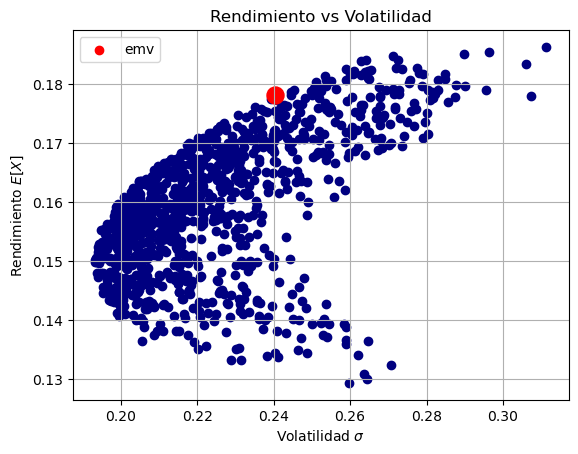

In [19]:
# Gráfica portafolios de markowitz 
plt.scatter(resultados.volatility, resultados.expected_value, c = 'navy')
plt.scatter(emv.volatility, emv.expected_value, c = 'red', s=150)
plt.scatter(emv.volatility, emv.expected_value, c = 'red', label = 'emv')

plt.legend()
plt.title('Rendimiento vs Volatilidad')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento $E[X]$')
plt.grid()

In [20]:
# Obten la linea de asignacion de capitales
emv_volatility = emv.volatility.values[0]
emv_expected_value = emv.expected_value.values[0]

In [21]:
# Define los pesos de los activos riesgosos de 0 a 150%
w_stock = np.linspace(0,1.5,100)
lac = pd.DataFrame({
    'vol': w_stock * emv_volatility,
    'expected_value': w_stock * emv_expected_value + (1-w_stock)*rf
})

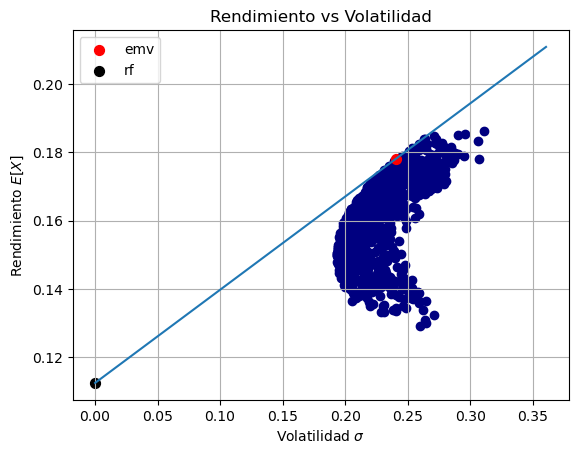

In [22]:
# Gráfica
plt.scatter(resultados.volatility, resultados.expected_value, c = 'navy')
plt.scatter(emv.volatility, emv.expected_value, c = 'red', s=50, label = 'emv')

plt.scatter(0,rf, c = 'black', s = 50, label = 'rf')
plt.plot(lac.vol, lac.expected_value)

plt.legend()
plt.title('Rendimiento vs Volatilidad')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento $E[X]$')
plt.grid()

### ¿Cuanto en cada uno?

$$wOpt = \frac{E_p - rf}{\alpha * \sigma^2}$$


In [23]:
# Coeficiente de aversión de 1 a 20
alpha = np.linspace(1,20,20)

In [24]:
w_opt = pd.DataFrame({
    'aversión': alpha,
    'w_stock': (emv_expected_value-rf)/(alpha * emv_volatility**2),
    'w_cetes': 1 - (emv_expected_value-rf)/(alpha * emv_volatility**2)
})
w_opt

,aversión,w_stock,w_cetes
0,1.0,1.134343,-0.134343
1,2.0,0.567171,0.432829
2,3.0,0.378114,0.621886
3,4.0,0.283586,0.716414
4,5.0,0.226869,0.773131
5,6.0,0.189057,0.810943
6,7.0,0.162049,0.837951
7,8.0,0.141793,0.858207
8,9.0,0.126038,0.873962
9,10.0,0.113434,0.886566


In [25]:
# Más riesgo más rendimiento? regresion lineal

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = summary[['volatility']]
y = summary[['means']]

model.fit(X, y)

LinearRegression()

In [27]:
model.coef_

array([[0.5898368]])

In [28]:
model.intercept_

array([-0.02009623])

Rendimiento = -0.02 + 0.5898 * volatilidad

In [29]:
summary['predicciones'] = model.predict(X)

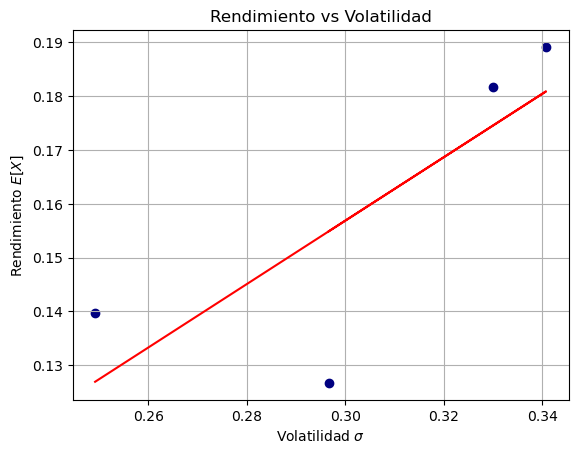

In [30]:
plt.scatter(summary.volatility, summary.means, c = 'navy')
plt.plot(summary.volatility, summary.predicciones, c = 'red')

plt.title('Rendimiento vs Volatilidad')
plt.xlabel('Volatilidad $\sigma$')
plt.ylabel('Rendimiento $E[X]$')
plt.grid()